<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/deeplearning.ai/tf/load_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Images

We will explore loading and preprocessing an image dataset using three different methods.

1. High-level Keras preprocessing utilities and layers.
2. Creating input pipelines using tf.data.
3. Using dataset from the tf repository.

## Setup

In [3]:
import os
import pathlib
import PIL
import PIL.Image
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
tf.__version__

'2.3.0'

## Download the flowers dataset

We will work with a dataset of thousands photos of flowers. The flowers dataset contains 5 sub-directories:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```


In [6]:
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file(
    origin=dataset_url,
    fname='flower_photos',
    untar=True
)
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

After downloading (218MB), you should now have a copy of the flower photos available. There are 3670 total images:

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [11]:
roses = list(data_dir.glob('roses/*'))
print(f'roses count: {len(roses)}')

roses count: 641


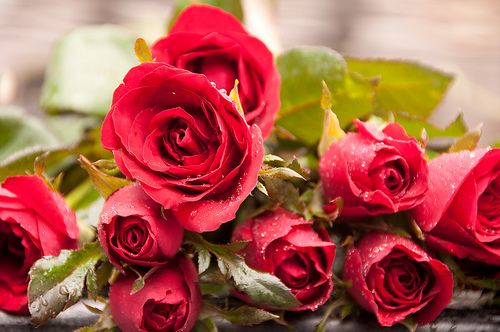

In [12]:
PIL.Image.open(str(roses[0]))